In [21]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Activation, BatchNormalization, MaxPool2D
import data_preprocessing as dp

import models.training as train
import utilities

In [22]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Import data

In [23]:
rf_data = {key:tf.data.experimental.load(f'dataset/preprocessed/reshaped_pca98train_ds/{key}')
           for key in ('train', 'test', 'valid')}
channel_data = {key:tf.data.experimental.load(f'dataset/preprocessed/channel_pca98train_ds/{key}')
           for key in ('train', 'test', 'valid')}
time_data = {key:tf.data.experimental.load(f'dataset/preprocessed/time_pca98train_ds/{key}')
             for key in ('train', 'test', 'valid')}

In [24]:
channel_data

{'train': <_LoadDataset shapes: ((None, 46, 640, 1), (None, 4)), types: (tf.float64, tf.float32)>,
 'test': <_LoadDataset shapes: ((None, 46, 640, 1), (None, 4)), types: (tf.float64, tf.float32)>,
 'valid': <_LoadDataset shapes: ((None, 46, 640, 1), (None, 4)), types: (tf.float64, tf.float32)>}

In [25]:
rf_data

{'train': <_LoadDataset shapes: ((None, 1319), (None, 4)), types: (tf.float64, tf.float32)>,
 'test': <_LoadDataset shapes: ((None, 1319), (None, 4)), types: (tf.float64, tf.float32)>,
 'valid': <_LoadDataset shapes: ((None, 1319), (None, 4)), types: (tf.float64, tf.float32)>}

In [26]:
time_data

{'train': <_LoadDataset shapes: ((None, 128, 39, 1), (None, 4)), types: (tf.float64, tf.float32)>,
 'test': <_LoadDataset shapes: ((None, 128, 39, 1), (None, 4)), types: (tf.float64, tf.float32)>,
 'valid': <_LoadDataset shapes: ((None, 128, 39, 1), (None, 4)), types: (tf.float64, tf.float32)>}

### Dense Model

In [47]:
class FF(Model):
    def __init__(self, input_dim):
        """
        init: constructor of model
        call: performs forward pass of model
        """
        super(FF, self).__init__()
        self.input_dim = input_dim
        self.layer_list = [
            Dense(self.input_dim, activation="sigmoid"),
            #Dense(258, activation="sigmoid"),
            #Dense(128, activation="sigmoid"),
            Dense(32, activation="sigmoid"),
            Dense(32, activation="sigmoid"),
            Dense(4, activation= "softmax")
        ]

    @tf.function
    def call(self, inputs) -> tf.Tensor:
        """ Computes a forward step with the given data
        Parameters
        ----------
        inputs : tf.Tensor
            the input for the model
        training : bool
            true if call has been made from train_step, which tells the dropout layer to be active
        Returns
        ----------
        x : tf.Tensor
            the output of the model
        """
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        return x


In [48]:
dense = FF(1319)
dense.build((None, 1319))
dense.summary()

Model: "ff_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             multiple                  1741080   
_________________________________________________________________
dense_28 (Dense)             multiple                  84480     
_________________________________________________________________
dense_29 (Dense)             multiple                  2080      
_________________________________________________________________
dense_30 (Dense)             multiple                  132       
Total params: 1,827,772
Trainable params: 1,827,772
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Initialize the loss-function
loss_func = tf.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD()

In [50]:
# Initialize Train-Object
trainer_1 = train.Trainer(dense, rf_data,
                        optimizer, loss_func, train.accuracy)

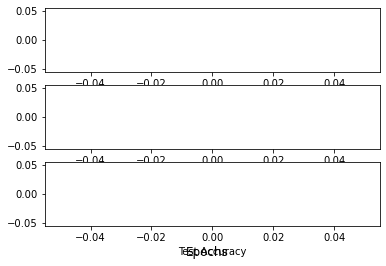

In [51]:
# Initialize Plotting-Object
grapher_1 = utilities.TrainingGrapher(3, 1, supxlabel='Epochs',
                                    axs_xlabels=[['Train Loss', 'Test Loss', 'Test Accuracy']])

In [52]:
for epoch in range(100):
    print("Epoch:", epoch, end='\r')
    trainer_1.train_epoch()
    grapher_1.update([trainer_1.losses['train'], trainer_1.losses['test'], trainer_1.accuracies['test']])

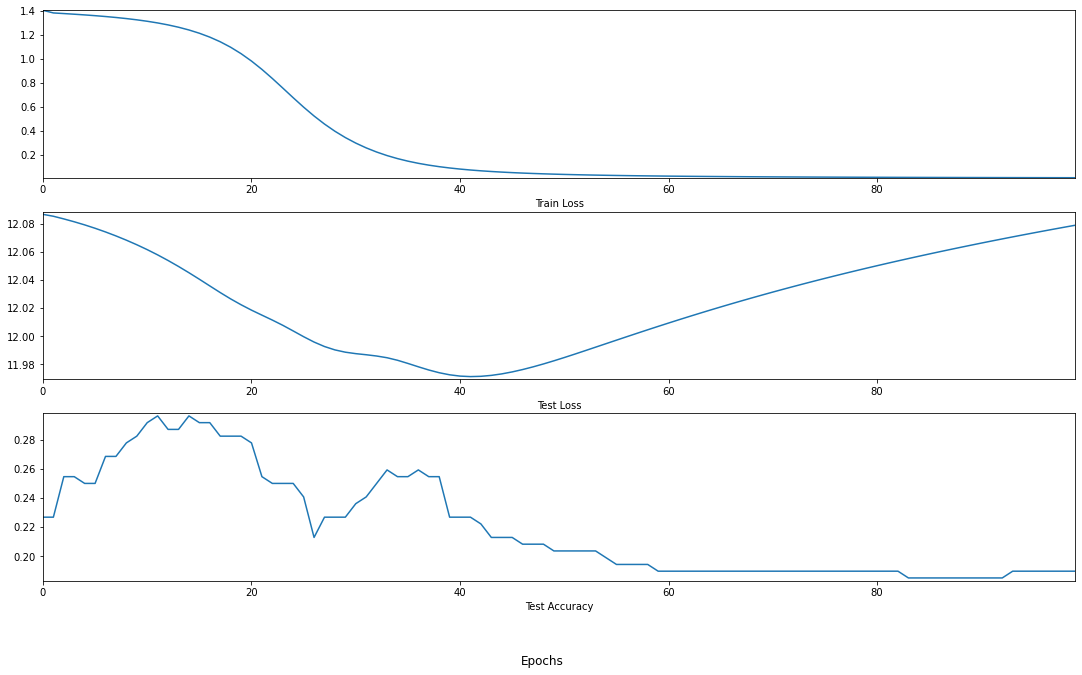

In [53]:
%matplotlib inline
grapher_1.fig.set_size_inches(18.5, 10.5)
grapher_1.fig

### CNN

In [13]:
class Conv(Model):
    def __init__(self):
        """
        init: constructor of model
        call: performs forward pass of model
        """
        super(Conv, self).__init__()

        self.layer_list = [
            #Conv2D(filters=32, kernel_size=(3,3), padding = 'same'),
            #BatchNormalization(),
            #LeakyReLU(),
            #MaxPool2D(),
            Conv2D(filters=16, kernel_size=(3,3), padding = 'same'),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.3),
            MaxPool2D(),
            Conv2D(filters=8, kernel_size=(3,3), padding = 'same'),
            BatchNormalization(),
            LeakyReLU(),
            tf.keras.layers.GlobalAveragePooling2D(),
            Dense(4, activation='softmax')
        ]

    @tf.function
    def call(self, inputs) -> tf.Tensor:
        """ Computes a forward step with the given data
        Parameters
        ----------
        inputs : tf.Tensor
            the input for the model
        training : bool
            true if call has been made from train_step, which tells the dropout layer to be active
        Returns
        ----------
        x : tf.Tensor
            the output of the model
        """
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        return x

In [46]:
model = Conv()
model.build((None, 46, 640, 1))
model.summary()

NameError: name 'Conv' is not defined

In [20]:
#%matplotlib tk
# Initialize the loss-function
loss_func = tf.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()



In [21]:
# Initialize Train-Object
trainer = train.Trainer(model, channel_data,
                        optimizer, loss_func, train.accuracy)

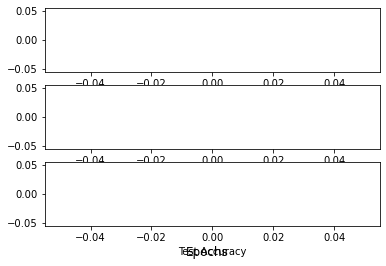

In [22]:
# Initialize Plotting-Object
grapher = utilities.TrainingGrapher(3,1, supxlabel='Epochs', axs_xlabels=[['Train Loss', 'Test Loss', 'Test Accuracy']])

In [23]:
for epoch in range(10):
    print("Epoch:", epoch, end='\r')
    trainer.train_epoch()
    grapher.update([trainer.losses['train'], trainer.losses['test'], trainer.accuracies['test']])

C:\Users\fkock\Documents\Master\Semester 2\Implementing ANNs with TensorFlow\inner_speech_decoding\utilities.py:75: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  self.axs[i%self.plot_shape[1], i//self.plot_shape[1]].set_xlim(min(xd), max(xd))


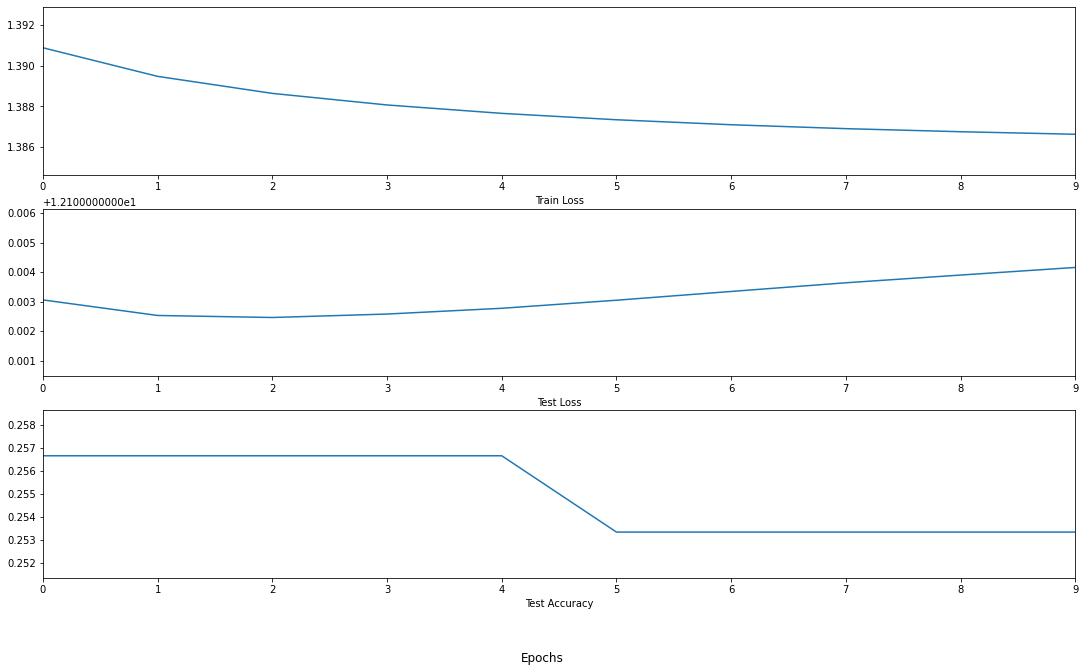

In [25]:
%matplotlib inline
grapher.fig.set_size_inches(18.5, 10.5)
grapher.fig